# Swithching Power e Conduction Power (Testing)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def poly_energy(current, params=[1,1,1,1]):
    
    ret = np.zeros(current.size)
    n_p = len(params) - 1
    
    for c, p in enumerate(params):
        # print('p', p)
        # print('n_p - c', n_p - c)
        ret += p * current ** (n_p - c)
        
    return ret

In [4]:
def detectCommutation(y):
    y1 = y[:-1]
    y2 = y[1:]
    
    diff = y2 - y1
    
    return y1, y2, diff

In [5]:
def tableSwitchingLosses(switch_s1, current, duration, step, eon_params=[1, 1, 1, 1],
                         eoff_params=[1, 1, 1, 1], erec_params=[1, 1, 1, 1]):
    '''
        Table with Switching Losses for TDD 2-Levels.
    '''
    _, _, commut = detectCommutation(switch_s1)
    
    commut_pos = commut == 1
    commut_neg = commut == -1
    
    current0 = current[1:]
    
    current_pos = current0 >= 0
    current_neg = current0 < 0
    
    comut_neg_cur_pos = commut_neg * current_pos
    comut_neg_cur_neg = commut_neg * current_neg
    comut_pos_cur_pos = commut_pos * current_pos
    comut_pos_cur_neg = commut_pos * current_neg
    
    current_comut_neg_cur_pos = np.abs(current0[comut_neg_cur_pos])
    current_comut_neg_cur_neg = np.abs(current0[comut_neg_cur_neg])
    current_comut_pos_cur_pos = np.abs(current0[comut_pos_cur_pos])
    current_comut_pos_cur_neg = np.abs(current0[comut_pos_cur_neg])

    # For 'S1'
    s1_eoff = poly_energy(current_comut_neg_cur_pos, params=eoff_params)
    s1_eon = poly_energy(current_comut_pos_cur_pos, params=eon_params)
    
    # For 'S2'
    s2_eoff = poly_energy(current_comut_pos_cur_neg, params=eoff_params)
    s2_eon = poly_energy(current_comut_neg_cur_neg, params=eon_params)
    
    # For 'D1'
    d1_rec = poly_energy(current_comut_neg_cur_neg, params=erec_params)
    
    # For 'D2'
    d2_rec = poly_energy(current_comut_pos_cur_pos, params=erec_params)
    
    P_sw = {
        'S1': 1/duration * (np.sum(s1_eoff) + np.sum(s1_eon)),
        'S2': 1/duration * (np.sum(s2_eoff) + np.sum(s2_eon)),
        'D1': 1/duration * (np.sum(d1_rec)),
        'D2': 1/duration * (np.sum(d2_rec))}
    
    return P_sw, ((commut_pos, commut_neg, current_pos, current_neg,
            (comut_neg_cur_pos, comut_neg_cur_neg), 
            (comut_pos_cur_pos, comut_pos_cur_neg), 
            (current_comut_neg_cur_pos, current_comut_neg_cur_neg),
            (current_comut_pos_cur_pos, current_comut_pos_cur_neg)))

## Testing the Switching Losses
### 1. Testando a detecção de comutação

In [5]:
y = np.random.randint(0, 2, size=10)
y1, y2, diff = detectCommutation(y)

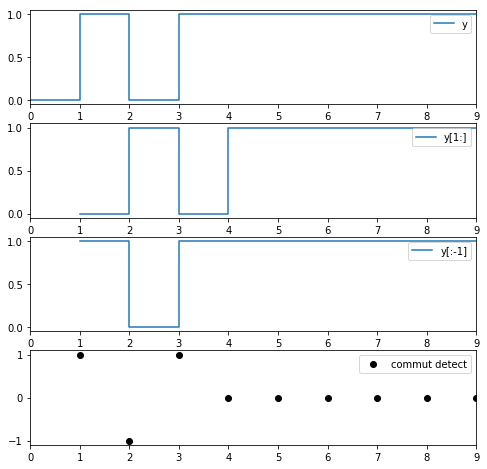

In [6]:
plt.figure(figsize=(8,8))
plt.subplot(411)
plt.step(range(10), y, where='post', label='y')
plt.xlim(0,9)
plt.legend()
plt.subplot(412)
plt.step(range(1, 10), y1, where='post', label='y[1:]')
plt.xlim(0,9)
plt.legend()
plt.subplot(413)
plt.step(range(1,10), y2, where='post', label='y[:-1]')
plt.xlim(0,9)
plt.legend()
plt.subplot(414)
plt.plot(range(1, 10), diff, 'ko ', label='commut detect')
plt.xlim(0,9)
plt.legend()
plt.show()

### 2. Mostrando o sinal simulado para o teste de perdas de comutação

In [7]:
size = 30

np.random.seed(5)
t = np.linspace(0, 2.25/60, size)
sim_switch  = np.random.randint(0, 2, size=size)
sim_current = 1000*np.sin(2*np.pi*60*t)

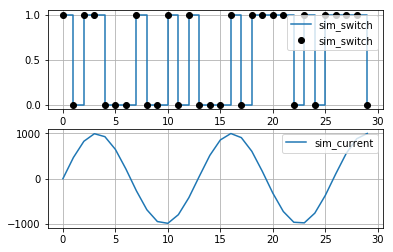

In [8]:
plt.subplot(211)
plt.step(range(sim_switch.size), sim_switch, label='sim_switch', where='post')
plt.plot(range(sim_switch.size), sim_switch, 'ko ', label='sim_switch')
plt.grid(True)
plt.legend()
plt.subplot(212)
plt.plot(sim_current, label='sim_current')
plt.grid(True)
plt.legend()
plt.show()

### 3. Parametrizando as curvas $E_{on}$, $E_{off}$ e $E_{rec}$, retiradas de um manual da ABB para o teste das perdas em comutação com os sinais acima

In [1]:
import numpy as np
# E_on = .4 + 5.63340539e-04*Ic + 5.48091255e-07*Ic**2<br>
# E_off = .05 + 1.86104115e-03*Ic -1.95635972e-07*Ic**2<br>
# E_rec = -3.45e-7 * Ic**2 + 1.45e-3 * Ic + 285e-3

# eon_params = [1,1,1,0]
# eoff_params = [1,1,1,10000000]
# erec_params = [1,1,1,20000000]

# Parâmetros de um manual da ABB
eon_params  = [5.48091255e-07, 5.63340539e-04, .4]
eoff_params = [-1.95635972e-07, 1.86104115e-03, .05]
erec_params = [-3.45e-7, 1.45e-3, 285e-3]

Vo_IGBT = -1
Ro_IGBT = -1

Vo_Diode = -1
Ro_Diode = -1

# Parâmetros de um manual da Semikron
eon_params  = np.array([1.23e-10, 1.39e-8, 6.96e-5, 4.64e-3]) #* 800/600
eoff_params = np.array([1.72e-10, -1.57e-7, 1.05e-4, -1.04e-3]) # * 800/600
erec_params = np.array([7.25e-11, -1.32e-7, 8.53e-5, 1.81e-3]) # * 800/600

Vo_IGBT = 3.85 # [V]
Ro_IGBT = 6.3*1e-3 # [ohm]

Vo_Diode = 2.5 #[V] 
Ro_Diode = 4.3*1e-3 # [ohm]

In [2]:
print('eon_params:', eon_params)
print('eoff_params:', eoff_params)
print('erec_params:', erec_params)

eon_params: [1.23e-10 1.39e-08 6.96e-05 4.64e-03]
eoff_params: [ 1.72e-10 -1.57e-07  1.05e-04 -1.04e-03]
erec_params: [ 7.25e-11 -1.32e-07  8.53e-05  1.81e-03]


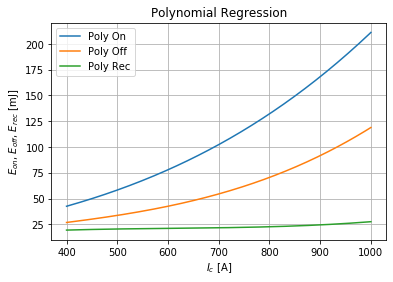

In [11]:
i = np.linspace(400, 1000, 200)

eon = np.poly1d(eon_params)(i)
eoff = np.poly1d(eoff_params)(i)
erec = np.poly1d(erec_params)(i)

import matplotlib.pyplot as plt

plt.plot(i, eon*1e3, label='Poly On')
plt.plot(i, eoff*1e3, label='Poly Off')
plt.plot(i, erec*1e3, label='Poly Rec')
plt.title('Polynomial Regression') 
plt.xlabel('$I_c$ [A]') 
plt.ylabel('$E_{on}$, $E_{off}$, $E_{rec}$ [mJ]')
plt.grid()
plt.legend()
# plt.yticks(np.arange(0, 110, 10))
# plt.xticks(np.arange(100, 650, 50))
# plt.xlim(50, 625)
plt.show()

In [12]:
P_sw, tmp = tableSwitchingLosses(sim_switch, sim_current, 
                                 t[-1], t[1] - t[0], 
                                 eon_params=eon_params, 
                                 eoff_params=eoff_params, 
                                 erec_params=erec_params)
a1, a2, b1, b2, c1, c2, d1, d2 = tmp

### 5. Plots que mostram quando a corrente foi detectada como positiva, negativa e o mesmo para a comutação

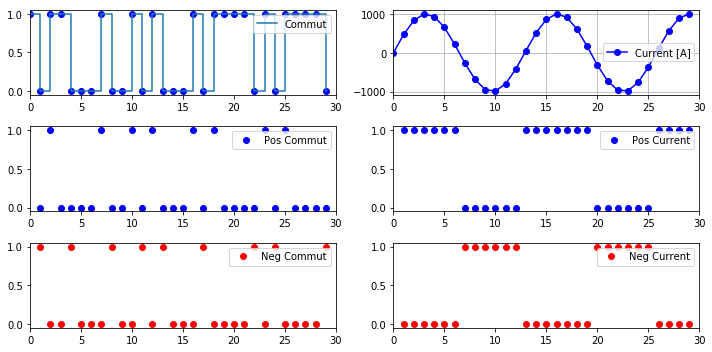

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(321)
plt.plot(range(size), sim_switch, 'bo')
plt.step(range(size), sim_switch, where='post', label='Commut')
plt.xlim(0, size)
plt.legend()

plt.subplot(322)
plt.plot(range(size), sim_current, 'bo-', label='Current [A]')
plt.xlim(0, size)
plt.grid(True)
plt.legend()

plt.subplot(323)
plt.plot(range(1, size), a1, 'bo', label='Pos Commut')
plt.xlim(0, size)
plt.legend()

plt.subplot(325)
plt.plot(range(1, size), a2, 'ro', label='Neg Commut')
plt.xlim(0, size)
plt.legend()

plt.subplot(324)
plt.plot(range(1, size), b1, 'bo', label='Pos Current')
plt.xlim(0, size)
plt.legend()

plt.subplot(326)
plt.plot(range(1, size), b2, 'ro', label='Neg Current')
plt.xlim(0, size)
plt.legend()

plt.tight_layout()
plt.show()

### 6. Multiplicação dos vetores de comutação e sentido da corrente para para setar o estado em comutação ocorreu e acumular devidamente $E_{on}$,  $E_{off}$ e $E_{rec}$

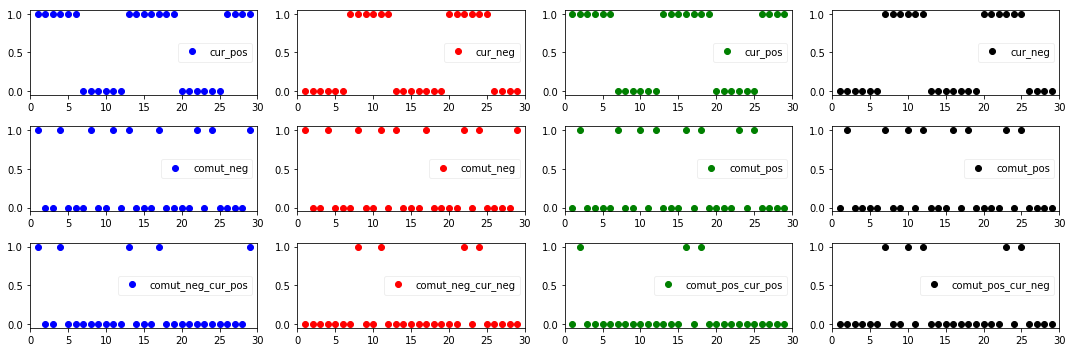

In [14]:
fig, ax = plt.subplots(3, 4, figsize=(15,5))

axi = [ax[1][0], ax[1][1]]
axi[0].plot(range(1, size), a2, 'bo', label='comut_neg')
axi[0].set_xlim(0, size)
axi[0].legend(framealpha=.3, loc='center right')
axi[1].plot(range(1, size), a2, 'ro', label='comut_neg')
axi[1].set_xlim(0, size)
axi[1].legend(framealpha=.3, loc='center right')

axi = [ax[1][2], ax[1][3]]
axi[0].plot(range(1, size), a1, 'go', label='comut_pos')
axi[0].set_xlim(0, size)
axi[0].legend(framealpha=.3, loc='center right')
axi[1].plot(range(1, size), a1, 'ko', label='comut_pos')
axi[1].set_xlim(0, size)
axi[1].legend(framealpha=.3, loc='center right')

axi = [ax[0][0], ax[0][1]]
axi[0].plot(range(1, size), b1, 'bo', label='cur_pos')
axi[0].set_xlim(0, size)
axi[0].legend(framealpha=.3, loc='center right')
axi[1].plot(range(1, size), b2, 'ro', label='cur_neg')
axi[1].set_xlim(0, size)
axi[1].legend(framealpha=.3, loc='center right')

axi = [ax[0][2], ax[0][3]]
axi[0].plot(range(1, size), b1, 'go', label='cur_pos')
axi[0].set_xlim(0, size)
axi[0].legend(framealpha=.3, loc='center right')
axi[1].plot(range(1, size), b2, 'ko', label='cur_neg')
axi[1].set_xlim(0, size)
axi[1].legend(framealpha=.3, loc='center right')

axi = ax[2][0]
axi.plot(range(1, size), c1[0], 'bo', label='comut_neg_cur_pos')
axi.set_xlim(0, size)
axi.legend(framealpha=.3, loc='center right')

axi = ax[2][1]
axi.plot(range(1, size), c1[1], 'ro', label='comut_neg_cur_neg')
axi.set_xlim(0, size)
axi.legend(framealpha=.3, loc='center right')

axi = ax[2][2]
axi.plot(range(1, size), c2[0], 'go', label='comut_pos_cur_pos')
axi.set_xlim(0, size)
axi.legend(framealpha=.3, loc='center right')

axi = ax[2][3]
axi.plot(range(1, size), c2[1], 'ko', label='comut_pos_cur_neg')
axi.set_xlim(0, size)
axi.legend(framealpha=.3, loc='center right')

plt.tight_layout()
plt.show()

### 7.  Os vetores de corrente para cada estágio em que as comutações ocorreram

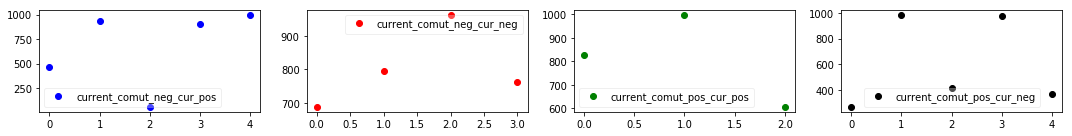

In [15]:
plt.figure(figsize=(15, 2))
plt.subplot(141)
plt.plot(d1[0], 'bo', label='current_comut_neg_cur_pos')
#plt.xlim(0, size)
plt.legend(framealpha=.3)

plt.subplot(142)
plt.plot(d1[1], 'ro', label='current_comut_neg_cur_neg')
#plt.xlim(0, size)
plt.legend(framealpha=.3)

plt.subplot(143)
plt.plot(d2[0], 'go', label='current_comut_pos_cur_pos')
#plt.xlim(0, size)
plt.legend(framealpha=.3)

plt.subplot(144)
plt.plot(d2[1], 'ko', label='current_comut_pos_cur_neg')
#plt.xlim(0, size)
plt.legend(framealpha=.3)
plt.tight_layout()
plt.show()

### 7. Resultado Final das potências dissipadas de cada um dos semicondutores $S_1$, $S_2$, $D_1$ e $D_2$ , em Watts

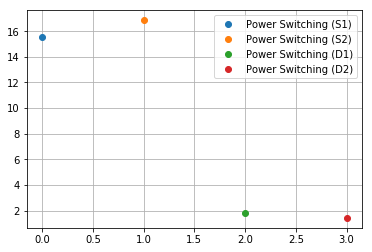

In [16]:
plt.plot([0], P_sw['S1'], 'o', label='Power Switching (S1)')
plt.plot([1], P_sw['S2'], 'o', label='Power Switching (S2)')
plt.plot([2], P_sw['D1'], 'o', label='Power Switching (D1)')
plt.plot([3], P_sw['D2'], 'o', label='Power Switching (D2)')
plt.grid()
plt.legend()
plt.show()

### Ap. Gráfico com os polinômios gerados para cada equação de energia

In [3]:
i = np.linspace(400, 1000, 200)

In [4]:
# eon = poly_energy(i, eon_params)
# eoff = poly_energy(i, eoff_params)
# erec = poly_energy(i, erec_params)


eon = np.poly1d(eon_params)(i)
eoff = np.poly1d(eoff_params)(i)
erec = np.poly1d(erec_params)(i)

In [5]:
print('eon_params:', eon_params)
print('eoff_params:', eoff_params)
print('erec_params:', erec_params)

eon_params: [1.23e-10 1.39e-08 6.96e-05 4.64e-03]
eoff_params: [ 1.72e-10 -1.57e-07  1.05e-04 -1.04e-03]
erec_params: [ 7.25e-11 -1.32e-07  8.53e-05  1.81e-03]


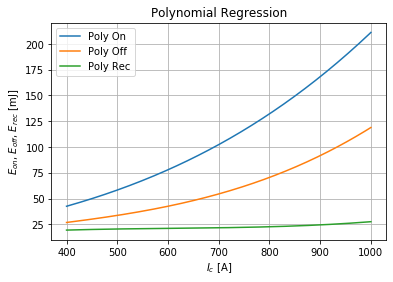

In [7]:
import matplotlib.pyplot as plt

plt.plot(i, eon*1e3, label='Poly On')
plt.plot(i, eoff*1e3, label='Poly Off')
plt.plot(i, erec*1e3, label='Poly Rec')
plt.title('Polynomial Regression') 
plt.xlabel('$I_c$ [A]') 
plt.ylabel('$E_{on}$, $E_{off}$, $E_{rec}$ [mJ]')
plt.grid()
plt.legend()
# plt.yticks(np.arange(0, 110, 10))
# plt.xticks(np.arange(100, 650, 50))
# plt.xlim(50, 625)
plt.show()

## Testing the Conduction Losses

In [25]:
def rmsValue(current):
    '''
    Calculate the RMS value.
    '''
    
    import numpy as np
    
    return np.sqrt(np.sum(np.power(current, 2)) / current.size)

In [26]:
def tableConductionLosses(switch_s1, current, Vo_IGBT, Vo_Diode, Ro_IGBT, Ro_Diode):
    '''
        Table with Switching Losses for TDD 2-Levels.
    '''
    
    switch_s1 = np.array(switch_s1)
    current = np.array(current)
    
    switch_s2 = np.zeros(switch_s1.size)
    switch_s2 = switch_s1 == 0
    
    pos_current = current >= 0
    neg_current = current < 0
    s1_times_current = switch_s1 * current
    s2_times_current = switch_s2 * current
    current_s1 = np.zeros(current.size)
    current_s1[pos_current] = s1_times_current[pos_current]
    current_d1 = np.zeros(current.size)
    current_d1[neg_current] = -1 * s1_times_current[neg_current]
    current_s2 = np.zeros(current.size)
    current_s2[neg_current] = -1 * s2_times_current[neg_current]
    current_d2 = np.zeros(current.size)
    current_d2[pos_current] = s2_times_current[pos_current]

    s1_cd = Vo_IGBT  * np.mean(current_s1) + Ro_IGBT  * np.power(rmsValue(current_s1), 2) 
    s2_cd = Vo_IGBT  * np.mean(current_s2) + Ro_IGBT  * np.power(rmsValue(current_s2), 2)
    d1_cd = Vo_Diode * np.mean(current_d1) + Ro_Diode * np.power(rmsValue(current_d1), 2)
    d2_cd = Vo_Diode * np.mean(current_d2) + Ro_Diode * np.power(rmsValue(current_d2), 2)
    
    P_cd = {'S1': s1_cd,
            'S2': s2_cd,
            'D1': d1_cd,
            'D2': d2_cd}
    
    return P_cd, ((switch_s1, switch_s2), 
                  (current_s1, current_d1, current_s2, current_d2),
                  (rmsValue(current_s1), rmsValue(current_d1), 
                   rmsValue(current_s2), rmsValue(current_d2)))

### 1. Generating the signals for test

In [33]:
size = 35

t = np.linspace(0, 1/60, size)

np.random.seed(5)

sim_switch_s1  = np.random.randint(0, 2, size=size)
sim_current = 1000*np.sin(2*np.pi*60*t )
Vdc = 800

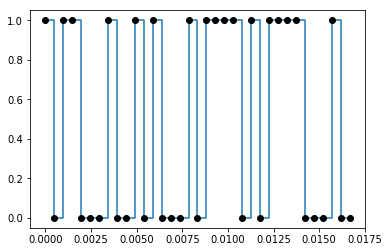

In [34]:
plt.step(t, sim_switch_s1, where='post')
plt.plot(t, sim_switch_s1, 'ko')

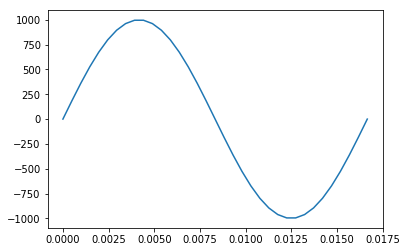

In [35]:
plt.plot(t, sim_current)

In [38]:
P_cd, tmp = tableConductionLosses(sim_switch_s1, sim_current, Vo_IGBT, Vo_Diode, Ro_IGBT, Ro_Diode)

((switch_s1, switch_s2), 
 (current_s1, current_d1, current_s2, current_d2), 
 (current_s1_rms, current_d1_rms, 
  current_s2_rms, current_d2_rms)) = tmp

### 3. Resultado do espelhamento do comando de $S_1$

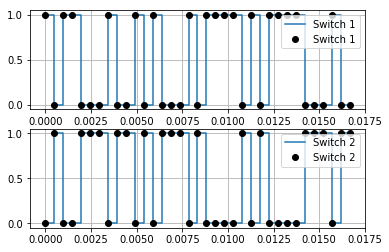

In [39]:
plt.subplot(211)
plt.step(t, switch_s1, label='Switch 1', where='post')
plt.plot(t, switch_s1, 'ko ', label='Switch 1')
plt.legend()
plt.grid()
plt.subplot(212)
plt.step(t, switch_s2, label='Switch 2', where='post')
plt.plot(t, switch_s2, 'ko ', label='Switch 2')
plt.legend()
plt.grid()

### 4. Plots que mostram que os semicondutores estão conduzindo nos momentos certos e no sentido correto da corrente

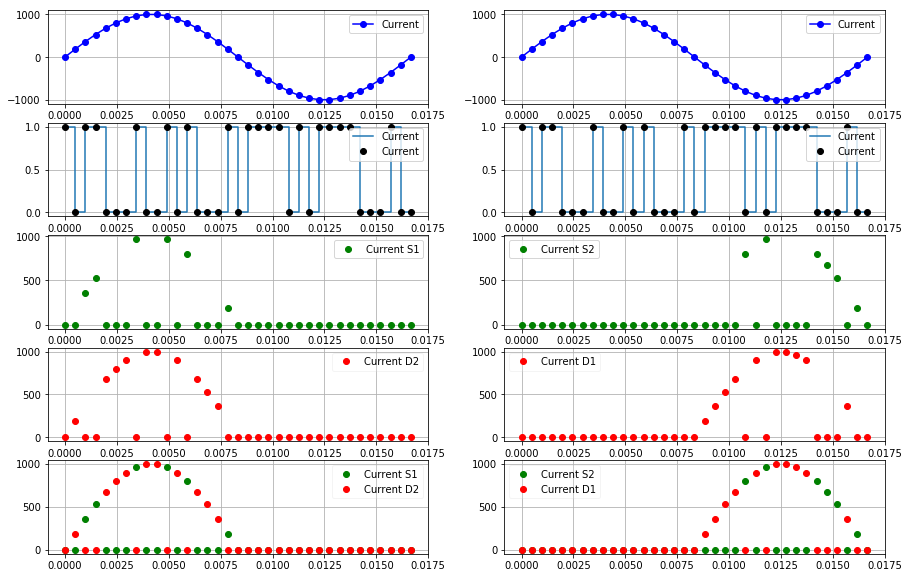

In [40]:
fig, ax = plt.subplots(5,2, figsize=(15, 10))

ax[0][0].plot(t, sim_current, 'bo-', label='Current')
ax[0][0].legend()
ax[0][0].grid()
# plt.subplot(522)
ax[0][1].plot(t, sim_current, 'bo-', label='Current')
ax[0][1].legend()
ax[0][1].grid()

ax[1][0].step(t, switch_s1, label='Current', where='post')
ax[1][0].plot(t, switch_s1, 'ko ', label='Current')
ax[1][0].legend()
ax[1][0].grid()
# plt.subplot(524)
ax[1][1].step(t, switch_s1, label='Current', where='post')
ax[1][1].plot(t, switch_s1, 'ko ', label='Current')
ax[1][1].legend()
ax[1][1].grid()

ax[2][0].plot(t, current_s1, 'go ', label='Current S1')
ax[2][0].legend()
ax[2][0].grid()
# plt.subplot(526)
ax[2][1].plot(t, current_s2, 'go ', label='Current S2')
ax[2][1].legend()
ax[2][1].grid()

ax[3][0].plot(t, current_d2, 'ro ', label='Current D2')
ax[3][0].legend(framealpha=.2)
ax[3][0].grid()
# plt.subplot(528)
ax[3][1].plot(t, current_d1, 'ro ', label='Current D1')
ax[3][1].legend(framealpha=.2)
ax[3][1].grid()

ax[4][0].plot(t, current_s1, 'go ', label='Current S1')
ax[4][0].plot(t, current_d2, 'ro ', label='Current D2')
ax[4][0].legend(framealpha=.2)
ax[4][0].grid()
# plt.subplot(5210)
ax[4][1].plot(t, current_s2, 'go ', label='Current S2')
ax[4][1].plot(t, current_d1, 'ro ', label='Current D1')
ax[4][1].legend(framealpha=.2)
ax[4][1].grid()

### 5. Plot que mostram o valor RMS para cada uma das correntes avaliadas

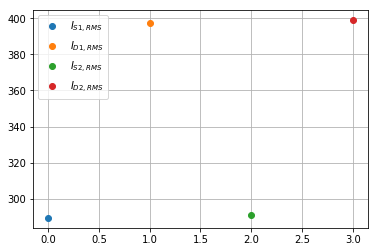

In [41]:
plt.plot([0], current_s1_rms, 'o', label='$I_{S1, RMS}$')
plt.plot([1], current_d1_rms, 'o', label='$I_{D1, RMS}$')
plt.plot([2], current_s2_rms, 'o', label='$I_{S2, RMS}$')
plt.plot([3], current_d2_rms, 'o', label='$I_{D2, RMS}$')
plt.legend()
plt.grid()
plt.show()

### 6. Resultado Final, as perdas em comutação para cada uma dos semicondutores, em Watts

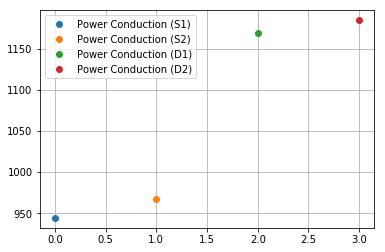

In [44]:
plt.plot([0], P_cd['S1'], 'o', label='Power Conduction (S1)')
plt.plot([1], P_cd['S2'], 'o', label='Power Conduction (S2)')
plt.plot([2], P_cd['D1'], 'o', label='Power Conduction (D1)')
plt.plot([3], P_cd['D2'], 'o', label='Power Conduction (D2)')
plt.grid()
plt.legend()
plt.show()

### Ap. Plot que mostra a condução completa feita por todos os semicondutores cada um em um momento

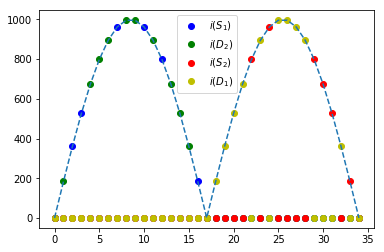

In [43]:
plt.plot(current_s1, 'bo', label='$i(S_1)$')
plt.plot(current_d2, 'go', label='$i(D_2)$')
plt.plot(current_s2, 'ro', label='$i(S_2)$')
plt.plot(current_d1, 'yo', label='$i(D_1)$')
plt.plot(np.abs(sim_current), '--')
plt.legend()
plt.show()